In [1]:
import torch
from numpy.ma.core import size
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

from model import FFN
from data_reader import SingleImageDataset

In [2]:
img_path = r'data/'

Check GPU device

In [3]:
device = ("cuda"
      if torch.cuda.is_available()
      else "mps"
      if torch.backends.mps.is_available()
      else "cpu")

print(f"Using {device} device")

Using cuda device


Set Learning rate, training batch size, and positional encoding parameters

In [54]:
lr = 1e-4
b_size = 128


Initailize data loader, model and optimizer

In [55]:
net = FFN(input_dim=2*mapping_size).to(device)

dataset = SingleImageDataset(img_path + 'image.png')
dataloader = DataLoader(dataset, batch_size=b_size, shuffle=False)

# We are training the network for pixels,
# so will do a pixelwise MSE loss
criterion = torch.nn.MSELoss()

# Optimizer and number of epochs
optimizer = torch.optim.Adam(net.parameters(), lr=lr)
NUM_EPOCHS = 200

Position encoding:
Referred from https://github.com/tancik/fourier-feature-networks/tree/master

In [56]:
mapping_size = 100
scale = 10
B = scale * torch.randn(mapping_size, 2).to(device)

def input_mapping(B, x):
        # Gaussian Fourier feature mapping
        X_proj = (2.*torch.pi*x) @ B.T
        out = torch.cat([torch.cos(X_proj), torch.sin(X_proj)], dim=-1)
        return out

Putting all togather and train the model

In [57]:
loss_values = []

# train and store loss values
for epoch in range(NUM_EPOCHS):
  for batch in dataloader:
    x, y, actual = batch["x"], batch["y"], batch["intensity"]
    x = x / dataset.w # normalizing x between 0 and 1
    y = y / dataset.h # normalizing y between 0 and 1
      
    coord = torch.stack((x, y), dim=-1).to(device)
    
    # Positional encoding
    pose_coord = input_mapping(B, coord)
      
    ### Assemble coord from x and y, pass to net, compute loss
    pred = net(pose_coord)
    loss = criterion(pred, actual.float().to(device))
      
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # Track loss
  loss_values.append(loss.item())
  avg_loss = sum(loss_values) / len(loss_values)
  print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}], Loss: {avg_loss}")
  
torch.save(net.state_dict(), img_path+'pos_encode_model.pt')


Epoch [1/200], Loss: 0.005165149457752705
Epoch [2/200], Loss: 0.004851897247135639
Epoch [3/200], Loss: 0.004591283233215411
Epoch [4/200], Loss: 0.004492293228395283
Epoch [5/200], Loss: 0.004479303583502769
Epoch [6/200], Loss: 0.006444420975943406
Epoch [7/200], Loss: 0.006136760248669556
Epoch [8/200], Loss: 0.005908320075832307
Epoch [9/200], Loss: 0.005953284860071208
Epoch [10/200], Loss: 0.005729345302097499
Epoch [11/200], Loss: 0.005423918408765035
Epoch [12/200], Loss: 0.005252098063162218
Epoch [13/200], Loss: 0.005091509477307017
Epoch [14/200], Loss: 0.005389366614898401
Epoch [15/200], Loss: 0.005236541417737802
Epoch [16/200], Loss: 0.005068010272225365
Epoch [17/200], Loss: 0.005014572018647895
Epoch [18/200], Loss: 0.004922970017004345
Epoch [19/200], Loss: 0.004745136750371833
Epoch [20/200], Loss: 0.004615021031349897
Epoch [21/200], Loss: 0.004554771773871921
Epoch [22/200], Loss: 0.004452446898953481
Epoch [23/200], Loss: 0.004575340401219285
Epoch [24/200], Loss

Plot training loss over epoch

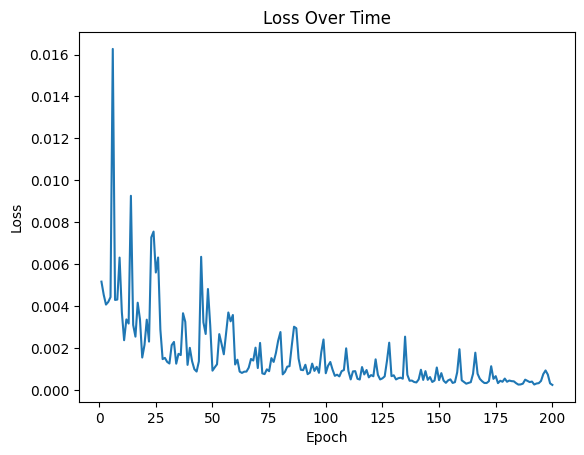

In [58]:
plt.plot(range(1, NUM_EPOCHS + 1), loss_values)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.show()


In [59]:
model_path = img_path + 'pos_encode_model.pt'
net.load_state_dict(torch.load(model_path))
net.eval()

FFN(
  (layers): Sequential(
    (0): Linear(in_features=200, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=3, bias=True)
  )
)

Evaluation

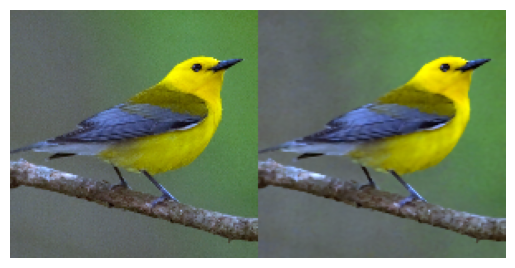

In [60]:
from torchvision.io import read_image


img = read_image(img_path+'image.png')

gt_image = torch.zeros(img.shape)
pred_image = torch.zeros(img.shape)

dataloader = DataLoader(dataset, batch_size=1, shuffle=False)
with torch.no_grad():
  for batch in dataloader:
    x, y, intensity = batch["x"], batch["y"], batch["intensity"]
    gt_image[:, y.item(), x.item()] = intensity*255

    x_ = x / dataset.w # normalizing x between 0 and 1
    y_ = y / dataset.h # normalizing y between 0 and 1

    coord = torch.stack((x_, y_), dim=-1)
    pos_coord = input_mapping(B, coord.to(device))
    
    pred = net(pos_coord)

    pred_image[:, y.item(), x.item()] = pred * 255

pred_image = torch.clip(pred_image, 0, 255)

joint_image = torch.cat([gt_image.type(torch.uint8), pred_image.type(torch.uint8)], dim=2)
plt.imshow(joint_image.permute(1, 2, 0))
plt.axis('off')
plt.show()
plt.close()

PSNR

In [61]:
if gt_image.shape != pred_image.shape:
    raise ValueError("Two images must have the same dimensions.")

mse = torch.nn.functional.mse_loss(gt_image, pred_image)

max_value = torch.tensor(255, dtype=torch.uint8)

psnr = 20 * torch.log10(max_value) - 10 * torch.log10(mse)

print(f'PSNR: {psnr.item()} dB')

PSNR: 32.796165466308594 dB
